# Mapping aerobic habitat in trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy
import cartopy.crs as ccrs
import cmocean

import data_collections as dc
import funnel
import util

In [3]:
sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids,
)
catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,32
variable,8
name,1
path,464


In [4]:
cat = catalog.search(variable='vol_habitat_trait_spc')
cat.df.head()

,experiment,component,stream,member_id,variable,name,path
0,20C,ocn,pop.h,9,vol_habitat_trait_spc,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
1,20C,ocn,pop.h,10,vol_habitat_trait_spc,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
2,20C,ocn,pop.h,11,vol_habitat_trait_spc,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
3,20C,ocn,pop.h,12,vol_habitat_trait_spc,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
4,20C,ocn,pop.h,13,vol_habitat_trait_spc,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...


In [5]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='8GB')
    cluster.scale(6)
client    

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45847 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/45847/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/45847/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.22:43894,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/45847/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
cat = catalog.search(variable='vol_habitat_trait_spc')
dsets = cat.to_dataset_dict(zarr_kwargs={'use_cftime': True}) 
keys = list(dsets.keys())

exp_keys = ['20C.ocn.pop.h.drift-corrected', 'RCP85.ocn.pop.h.drift-corrected']
ds = xr.concat([dsets[k] for k in exp_keys], dim='time', coords='minimal').compute()

ds.vol_habitat_trait_spc.data *= 1e-6 * 1e-6  # convert from cm^3 to 10^6 m^6
ds.vol_habitat_trait_spc.attrs['units'] = '10$^6$ m$^3$'
ds.vol_habitat_trait_spc.attrs['long_name'] = 'Aerobic habitat volume'

ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


<xarray.Dataset>
Dimensions:                (Ac: 8, Eo: 7, time: 2172, member_id: 31)
Coordinates:
  * Ac                     (Ac) float64 0.0258 0.0399 0.0619 ... 0.3568 0.5528
  * Eo                     (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * time                   (time) object 1920-01-17 00:29:59.999993 ... 2100-...
  * member_id              (member_id) int64 9 10 11 12 13 ... 102 103 104 105
Data variables:
    vol_habitat_trait_spc  (member_id, Ac, Eo, time) float64 0.0 0.0 ... 3.1e+11
Attributes:
    intake_esm_varname:      ['vol_habitat_trait_spc']
    intake_esm_dataset_key:  20C.ocn.pop.h.drift-corrected

In [7]:
yrfrac = util.year_frac(ds.time)
tndx_ref = np.where(yrfrac < 1966)[0]
tndx_2100 = np.where(yrfrac > 2080)[0]

In [8]:
with xr.set_options(keep_attrs=True):
    vol_hab_ref = ds.vol_habitat_trait_spc.isel(time=tndx_ref).mean(['member_id', 'time'])
    vol_hab_ref_std = ds.vol_habitat_trait_spc.isel(time=tndx_ref).std(['member_id', 'time'])

    vol_hab_2100 = ds.vol_habitat_trait_spc.isel(time=tndx_2100).mean(['member_id', 'time'])
    vol_hab_2100_std = ds.vol_habitat_trait_spc.isel(time=tndx_2100).std(['member_id', 'time'])

    # vol_hab_ref_percent = 100.0 * vol_hab_ref / total_volume
    # vol_hab_ref_percent.attrs['long_name'] = 'Ocean volume'
    # vol_hab_ref_percent.attrs['units'] = '%'

vol_hab_2100

<xarray.DataArray 'vol_habitat_trait_spc' (Ac: 8, Eo: 7)>
array([[0.00000000e+00, 0.00000000e+00, 1.29009094e+02, 3.86917284e+05,
        2.92439472e+08, 2.77695417e+10, 9.06503626e+10],
       [3.03807576e+07, 4.76209096e+06, 3.94531066e+07, 1.09296157e+10,
        7.98274666e+10, 1.19127362e+11, 1.35613258e+11],
       [4.66720737e+10, 4.05575317e+10, 6.15290308e+10, 1.35956198e+11,
        1.52920393e+11, 1.62840187e+11, 1.71874601e+11],
       [1.15763134e+11, 1.49111446e+11, 1.88751811e+11, 1.94174354e+11,
        1.97607585e+11, 2.03028907e+11, 2.12035733e+11],
       [1.82005398e+11, 2.26200202e+11, 2.34706400e+11, 2.35361204e+11,
        2.38522066e+11, 2.44661301e+11, 2.50504453e+11],
       [2.40834337e+11, 2.50746434e+11, 2.60397414e+11, 2.68918378e+11,
        2.72353595e+11, 2.75510129e+11, 2.78612988e+11],
       [2.62072179e+11, 2.72083275e+11, 2.82056183e+11, 2.90804551e+11,
        2.96441110e+11, 2.97356687e+11, 2.97203770e+11],
       [2.82229083e+11, 2.90852622e+11, 2.98680095e+11, 3.05726062e+11,
        3.10539757e+11, 3.13125936e+11, 3.11899039e+11]])
Coordinates:
  * Ac       (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
  * Eo       (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Attributes:
    units:      10$^6$ m$^3$
    long_name:  Aerobic habitat volume

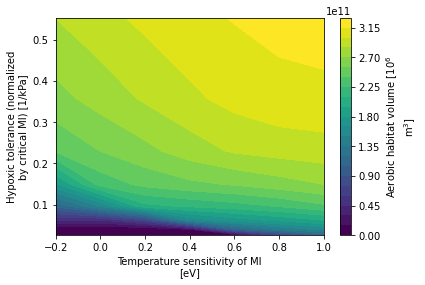

In [9]:
vol_hab_ref.plot.contourf(levels=30)

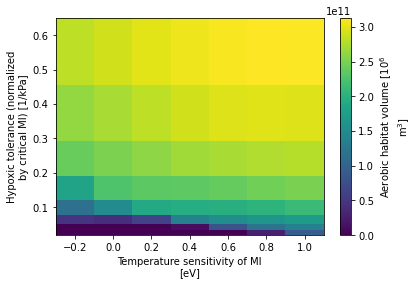

In [10]:
vol_hab_2100.plot()

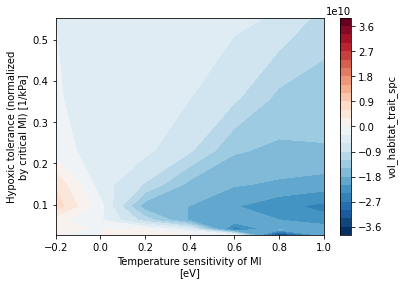

In [11]:
(vol_hab_2100 - vol_hab_ref).plot.contourf(levels=30)

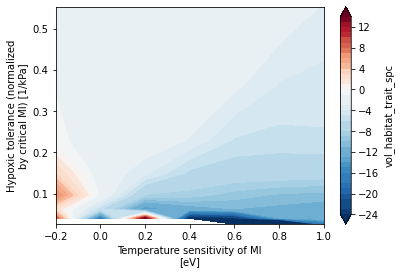

In [57]:
change_percent = (100.0 * (vol_hab_2100 - vol_hab_ref) / vol_hab_ref.where(vol_hab_ref>1e5))

mx = np.floor(change_percent.max())
mn = -24.0
divnorm = colors.TwoSlopeNorm(vmin=mn, vcenter=0, vmax=mx)
dx = 1.

change_percent.plot.contourf(norm=divnorm, levels=np.arange(mn, mx+dx, dx), extend='both');

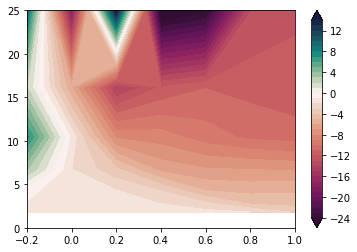

In [65]:
change_percent = (100.0 * (vol_hab_2100 - vol_hab_ref) / vol_hab_ref.where(vol_hab_ref>1e5))
mx = np.floor(change_percent.max())
mn = -24.0
dx = 1.

cf = plt.contourf(
    change_percent.Eo, 
    1.0/change_percent.Ac,
    change_percent, 
    levels=np.arange(mn, mx+dx, dx),
    norm=colors.TwoSlopeNorm(vmin=mn, vcenter=0, vmax=mx),
    extend='both',
    cmap=cmocean.cm.curl_r,
)
plt.ylim(0, 25)
plt.colorbar(cf)